*UCSB MEDS* - *EDS 220 - Working With Environmental Datasets in Python*

# Pheonix Biodiversity Intactness Index Analysis
### Mapping the Change in Biodiversity from 2017 - 2020 in Phoenix, Arizona

**Author:** Nicole Pepper

![Python](https://img.shields.io/badge/Python-cornflowerblue?style=for-the-badge&logo=R) ![Remote Sensing](https://img.shields.io/badge/Remote_Sensing-green?style=for-the-badge) ![GIS](https://img.shields.io/badge/GIS-purple?style=for-the-badge)  ![UCSB MEDS](https://img.shields.io/badge/UCSB%20MEDS-blue?style=for-the-badge) 


<div style="text-align: left;">
  <img src="bii.jpg" alt="Image" width="900">
    

### About the Repo:
This notebook investigates the impacts of urban expansion by analyzing a dataset that captures values for the [Biodiversity Intactness Index (BII)](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf). [In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems. I examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.

### Technical Highlights:
- Programming in Python using `Jupyter Lab`
- Data retreival from Microsoft STAC catalog with `pystac_client`
- Vector data wrangling with `gpd`
- Raster data wrangling with `rioxarray` and `xarray`
- Data visualization with `matplotlib`
- Creating a map gif with `geogif`
    
### Data Descriptions:

- The `Biodiversity Intactness Index (BII) Time Series` data is a collection of ...... It is from ..... I accessed the data using the `io-biodviersity` collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). I use the 2017 and 2020 rasters covering the Pheonix subdivision.

- The `Pheonix Subdivision Shapefile` data is a shapefile containing the perimeters of the Pheonix metro area. It is a subset of the Census County Subdivision shapefiles for Arizona. The data is a subset of Census County Subdivision shapefiles from the [U.S. Census Bureau](https://www.census.gov/programs-surveys/acs) from 2020 for Arizona. I accessed it on the [U.S. Census Bureau website](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions).

# NOTE: 

I had difficulty plotting the data together for the last map. I think that it is because the way that I classified the 2017 and 2020 rasters removed their CRS. I tried it a few ways and wasn't able to figure it out. I couldn't find any resources on the course website and had trouble finding other examples. I'll keep working on it this week. 

I apologize that I wasn't able to get it done in time. I have a big event for work next week so my workload was at capacity this week. 

Best,
Nicole

# 1. Set Up Workspace

### 1a. Load libraries

In [63]:
# ---- Load libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images
from geogif import gif
fro
m shapely.geometry import box
import xarray as xr
import os
from IPython.display import Image, display, HTML # for visualizing images
import contextily as cx # for map background data
from PIL import Image
from io import BytesIO
import requests
from matplotlib.colors import ListedColormap

### 1b. Read in Project Data

In [2]:
# ----- Read in Phoenix subdivision boundary ------

# Read in Arizona subdivisions data
arizona_sds = gpd.read_file("data/tl_2020_04_cousub.shp")

# Subset to phoenix
phoenix = arizona_sds[arizona_sds['NAME'] == 'Phoenix']


In [3]:
# ----- Read in bii data ------

# Define Pheonix bbox

bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# ----- Access MPC catalog ------

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Access MPC collections as a list
catalog.get_collections()
collections = list(catalog.get_collections())


# Define temporal range for 2017 and 2020
time_ranges = ["2017-01-01/2017-12-31", "2020-01-01/2020-12-31"]

# Initialize an empty list to collect items
items = []

# Define for loop to iterate search for both time ranges
for time_range in time_ranges:
    search = catalog.search(
        collections=["io-biodiversity"],
        bbox=bbox,
        datetime=time_range
    )
    items.extend(list(search.items()))

# Print summary of found items
print(f"Found {len(items)} items matching the criteria.")

# Separate 2017 and 2020 images    
bii_2017_item = items[0]
bii_2020_item = items[1]

print(bii_2017_item.id)
print(bii_2020_item.id)

# ---- Retreive BII data from items ----

# Get 2017 Phoenix data
bii_2017 = bii_2017_item.assets["data"]

bii_2017 = rioxr.open_rasterio(bii_2017.href)

# Get 2020 Phoenix data

bii_2020 = bii_2020_item.assets["data"]

bii_2020 = rioxr.open_rasterio(bii_2020.href)

Found 2 items matching the criteria.
bii_2017_34.74464974521749_-115.38597824385106_cog
bii_2020_34.74464974521749_-115.38597824385106_cog


# 2. Prepare and Explore Preliminary Data

### 2a. Check CRS

In [4]:
# ---- Check CRS ----

# Set CRS to WGS 84 to match MPC data (EPSG: 4326) (bii_2017.rio.crs)
phoenix = phoenix.to_crs(bii_2017.rio.crs)

# Print the crs name 
print("The bii_2017 CRS is:", bii_2017.rio.crs)

# Print the crs name 
print("The bii_2020 CRS is:", bii_2020.rio.crs)

# Print the crs name
print("The phoenix CRS is:", phoenix.crs.name)

The bii_2017 CRS is: EPSG:4326
The bii_2020 CRS is: EPSG:4326
The phoenix CRS is: WGS 84


### 2b. Drop Bands for 2017 & 2020 BII Rasters

In [5]:
# ---- Remove length 1 dimension ----

# Drop band for bii 2017
bii_2017 = bii_2017.squeeze().drop_vars('band')
print('Sizes of dimensions: ', dict(bii_2017.sizes))

# Drop band for bii 2020
bii_2020 = bii_2020.squeeze().drop_vars('band')
print('Sizes of dimensions: ', dict(bii_2020.sizes))

Sizes of dimensions:  {'y': 7992, 'x': 7992}
Sizes of dimensions:  {'y': 7992, 'x': 7992}


### 2c. Clip BII data to the Phoenix boundary

In [6]:
# ---- Clip BII to Phoenix boundary ----
bii_2017_phoenix = bii_2017.rio.clip(phoenix.geometry, phoenix.crs, drop=True)
bii_2020_phoenix = bii_2020.rio.clip(phoenix.geometry, phoenix.crs, drop=True)

### 2d. Visualize Preliminary BII Data

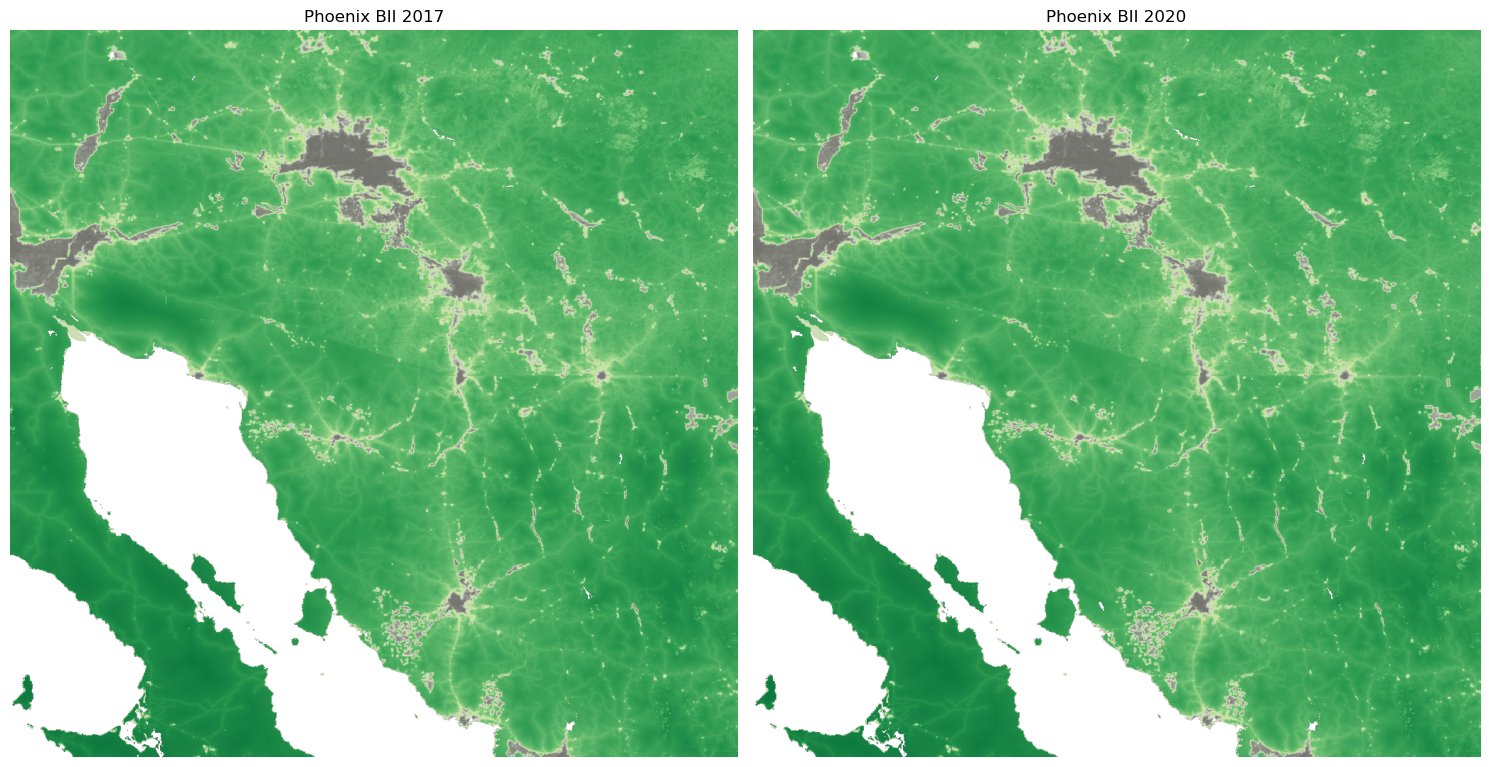

In [7]:
# ---- Retreive previews of bii data ----

# Define URLs for the 2017 and 2020 images
bii_2017_url = bii_2017_item.assets['rendered_preview'].href
bii_2020_url = bii_2020_item.assets['rendered_preview'].href

# Get image data from the URLs
request_2017 = requests.get(bii_2017_url)
request_2020 = requests.get(bii_2020_url)

# Load image data into a PIL Image object
image_2017 = Image.open(BytesIO(request_2017.content))
image_2020 = Image.open(BytesIO(request_2020.content))

# ---- Plot the previews side by side ----

# Set up fig with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Display the 2017 image
ax1.imshow(image_2017)
ax1.set_title("Phoenix BII 2017")
ax1.axis('off')  # Turn off axes

# Display the 2020 image
ax2.imshow(image_2020)
ax2.set_title("Phoenix BII 2020")
ax2.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

### 2e. Visualize Preliminary Phoenix Subdivision Data

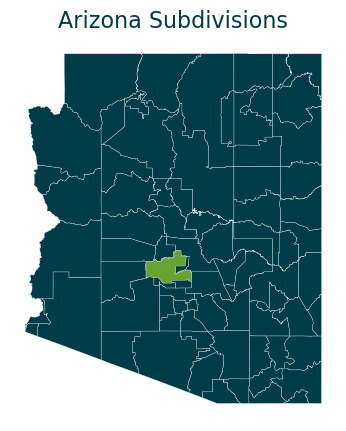

In [8]:
# ---- Map Arizona Subdivisions ----

# Set figure parameters
fig, ax = plt.subplots(figsize=(5, 5))

# Plot arizona subdivisions
arizona_sds.plot(ax=ax, color='#003B4A', edgecolor='white', linewidth = 0.2)

# Plot phoenix subdivision
phoenix.plot(ax=ax, color='#67A32F', edgecolor='white', linewidth = 0.2)

# Remove axes
ax.axis('off')

# Add a title and display the plot
plt.title("Arizona Subdivisions", fontsize=16, color='#003B4A')
plt.show()

# 3. Calculate the Percentage of Area of the Phoenix Subdivision with a BII of at least 0.75 for 2017 and 2018

### 3a. Reclassify Data for Threshold Where *BII > 0.75*

In [9]:
# ---- Reclassify data ----

# Create function to classify data with data and threshold value as inputs
def reclassify_data(data, threshold):
    reclassified = xr.where(data > threshold, 1, 0)
    return reclassified

# Reclassify data for 2017 and 2020
bii_2017_reclass = reclassify_data(bii_2017_phoenix, 0.75)
bii_2020_reclass = reclassify_data(bii_2020_phoenix, 0.75)

In [ ]:
# # Option 2 for reclassifying....
# # Defines the bins for pixel values
# class_bins = (0, 0.75, 0.75, 1)

# bii_2017_class = xr.apply_ufunc(
#     np.digitize,
#     bii_2017,
#     class_bins
# )

# bii_2020_class = xr.apply_ufunc(
#     np.digitize,
#     bii_2020,
#     class_bins
# )

### 3b. Calculate Percent Area for 2017 & 2020

In [10]:
# ---- Value Counts ----
values_2017, counts_2017 = np.unique(bii_2017_reclass.values, return_counts=True)
values_2020, counts_2020 = np.unique(bii_2020_reclass.values, return_counts=True)

print("2017 Value Counts:", dict(zip(values_2017, counts_2017)))
print("2020 Value Counts:", dict(zip(values_2020, counts_2020)))

2017 Value Counts: {1: 12795850, 3: 51076214}
2020 Value Counts: {1: 12892116, 3: 50979948}


#### Percent Area that is > 0.75 BII is 2017: *4.18%*
#### Percent Area that is > 0.75 BII is 2020: *3.8%*

#### *That's a 0.3 percent loss of high BII from 2017 to 2022 in Phoenix.*

# 4. Create a Map that Highlights Regions Where BII > 0.75 in 2017 Were Lost By 2020

### 4a. Find Where 2017 *BII > 0.75* Was Lost By 2020

In [77]:
# ---- Identify areas of biodiversity loss ---

# Subtract 2020 from 2017
bii_loss = bii_2017_reclass - bii_2020_reclass

# Convert DataArray to NumPy for indexing
bii_loss_np = bii_loss.values.astype(float)  # convert so we can set 0 to NA

# Set areas not equal to 1 to NaN
bii_loss_np[bii_loss_np != 1] = np.nan

# Reconvert NumPy array back to xarray.DataArray
bii_loss_xr = xr.DataArray(
    bii_loss_np,
    dims=bii_loss.dims, 
    coords=bii_loss.coords,
    attrs=bii_loss.attrs
 )

# Assign CRS
bii_loss_xr = bii_loss_xr.rio.write_crs(bii_2017.rio.crs)


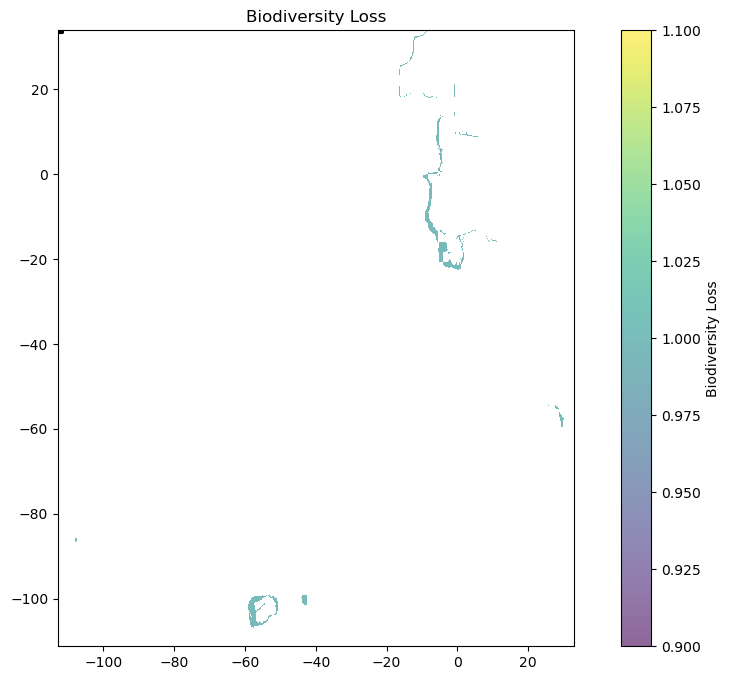

In [59]:
# ---- Plot Preliminary Results for Biodiversity Loss ----

# Define fig parameters
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the bii loss
cax = ax.imshow(
    bii_loss_np, 
    extent=bbox, 
    interpolation='none',
    alpha=0.6
)

phoenix.boundary.plot(ax=ax, edgecolor='black', linewidth=2)

# Add color bar and map elements
fig.colorbar(cax, ax=ax, orientation="vertical", label="Biodiversity Loss")
plt.title('Biodiversity Loss')

# Display the map
plt.show()

### 4b. Map Where 2017 *BII > 0.75* Was Lost By 2020

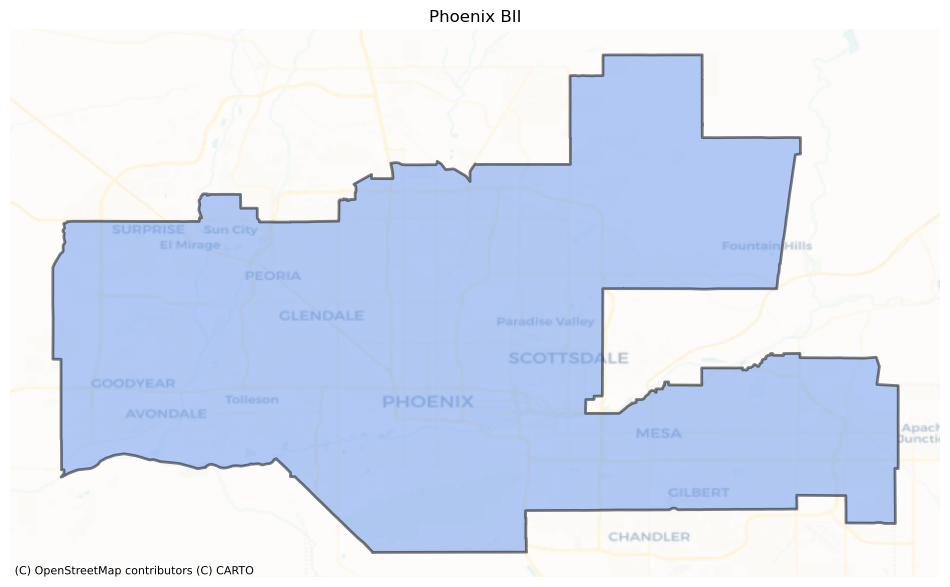

In [56]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Phoenix shapefile (vector data - the study area)
phoenix.plot(ax=ax, color="cornflowerblue", edgecolor='black', linewidth=2, alpha = 0.5)

# Add basemap with contextily clipped to bounding box
cx.add_basemap(ax,
               crs=phoenix.crs,
             source=cx.providers.CartoDB.Voyager)

# 0 is transparent, 1 is yellow
cmap = ListedColormap(["yellow", "white"])

# Use matplotlib's imshow with the raster extent
ax.imshow(
    bii_loss,
    extent=bbox,  # Define extent to match your spatial bounding box
    alpha=0.6,  # Adjust transparency
    interpolation="none",
    cmap=cmap
)

# Add map elements
plt.title('Phoenix BII')

# Turn off axis ticks for a cleaner map view
ax.set_axis_off()

# Display the map
plt.show()

In [ ]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Phoenix shapefile (vector data - the study area)
phoenix.plot(ax=ax, color="cornflowerblue", edgecolor='black', linewidth=2, alpha = 0.5)

# Add basemap with contextily clipped to bounding box
cx.add_basemap(ax,
               crs=phoenix.crs,
             source=cx.providers.CartoDB.Voyager)

# 0 is transparent, 1 is yellow
cmap = ListedColormap(["yellow", "white"])

# Use matplotlib's imshow with the raster extent
ax.imshow(
    bii_loss,
    extent=bbox,  # Define extent to match your spatial bounding box
    alpha=0.6,  # Adjust transparency
    interpolation="none",
    cmap=cmap
)

# Add map elements
plt.title('Phoenix BII')

# Turn off axis ticks for a cleaner map view
ax.set_axis_off()

# Display the map
plt.show()

### References:
  
- Vizzuality. (2022) *Biodiversity Intactness: White Paper*, https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf.

- Vizzuality. [Data] [Biodiversity Intactness Index (BII) Time Series](https://planetarycomputer.microsoft.com/dataset/io-biodiversity) for 2017 and 2020. *Access date: 12/05/24* from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

- U.S. Census Bureau (2020) [Data] Arizone Subdivisions Shapefile  *Access date: 12/05/24* https://www.census.gov/programs-surveys/acs